# RL Final Project

Now it's finally time to put into use what we have learned so far in this course!

The aim of this project is to assess your practical knowledge in Reinforcement Learning.

your project consist of 2 parts. you will get the chance to work with 2 different environment.


## 2.Atari Game Pong

**[Pong](https://www.gymlibrary.dev/environments/atari/pong/)** is a famus atari game that almost all of us have played it at least once!
The goal of this task is to get engage with **gym** library and use Deep Reinforcement Learning to train an agent which can actually play this game!

In [4]:
# !pip install ALE gym
!pip install "gym[accept-rom-license, atari]"


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


You might face some problems rendering the environments in colab. so for this task try running it locally in your machine.

In [113]:
import torch
import numpy

In [114]:
class LearningConstants:
    discount_factor: float = 0.99
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    width = 30
    height = 30
    policy_learning_rate = 0.01
    state_value_approximation_learning_rate = 0.01

In [115]:
from PIL import Image
from torchvision.transforms.functional import crop, to_grayscale, adjust_contrast, resize
class ProcessState:

    def __init__(self, tensor_state: torch.Tensor) -> None:
        self.tensor_state: torch.Tensor = tensor_state

    @staticmethod
    def fromObservation(observation: numpy.ndarray):

        observation = Image.fromarray(observation)
        observation = crop(observation, top=34, left=0, height=160, width=160)
        observation = resize(observation, [LearningConstants.height, LearningConstants.width])
        observation = adjust_contrast(to_grayscale(observation), 100.0)

        # observation.show()

        return ProcessState(
            tensor_state = torch.tensor(numpy.asarray(observation))
        )


    def __call__(self, *args, **kwargs) -> torch.Tensor:
        return self.tensor_state

In [116]:
class Step:

    def __init__(self, observation_tensor, action, reward, log_prob) -> None:
        self.observation_tensor = observation_tensor
        self.action = action
        self.reward = reward
        self.log_prob = log_prob


class History:

    def __init__(self) -> None:
        self.steps = []

    def addStep(self, step: Step) -> None:
        self.steps.append(step)

In [117]:
import torch.nn as nn
import numpy as np
from torch.nn.functional import sigmoid
class PolicyNetwork(torch.nn.Module):

    def __init__(self, shape, n_actions) -> None:
        super(PolicyNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=2, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out((30, 30))
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return sigmoid(self.fc(conv_out))

In [118]:


class StateValueApproximationNetwork(torch.nn.Module):

    def __init__(self, shape) -> None:
        super(StateValueApproximationNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=2, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out((30, 30))
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)


In [119]:
class Agent:
    def __init__(
            self,
            policy_network: PolicyNetwork,
            state_value_approximation_network: StateValueApproximationNetwork) -> None:
        self.policy_network: PolicyNetwork = policy_network
        self.state_value_approximation_network: StateValueApproximationNetwork = state_value_approximation_network

        self.policy_network_optimizer = torch.optim.Adam(self.policy_network.parameters(), lr = LearningConstants.policy_learning_rate)
        self.state_value_approximation_network_optimizer = torch.optim.Adam(self.state_value_approximation_network.parameters(),
                                                                            lr = LearningConstants.state_value_approximation_learning_rate)
        self.previous_state: ProcessState = None

    def selectAction(self, state: torch.Tensor) -> tuple:
        state_tensor: torch.Tensor = state.float().unsqueeze(0).to(LearningConstants.device)
        # print(state_tensor)
        # print(state_tensor.shape)
        probability_of_actions = self.policy_network(state_tensor)
        distr = torch.distributions.Categorical(probability_of_actions[0])
        action = distr.sample()
        return action.item(), distr.log_prob(action)

    def convertRewardsToCummulative(self, rewards_array: list) -> torch.Tensor:
        # CDR - Cummulative discounted rewards
        CDR = list()
        cummulation = 0
        for reward in rewards_array[::-1]:
            cummulation = reward + cummulation * LearningConstants.discount_factor
            CDR.append(cummulation)
        CDR.reverse()
        CDR = torch.tensor(CDR).to(LearningConstants.device)
        return ((CDR - CDR.mean()) / CDR.std())

    def trainPolicyNetwork(self, deltas, log_probs) -> float:
        policy_loss = []
        for i in range(len(deltas)):
            policy_loss.append(
                deltas[i] * log_probs[i] * -1
            )
        self.policy_network_optimizer.zero_grad()
        sum(policy_loss).backward()
        self.policy_network_optimizer.step()
        return sum(policy_loss).item()

    def trainStateValueApproximationNetwork(self, CDR, SPV) -> float:
        #CDR - cummulative discounted reward
        #SPV - state predicted values
        loss = torch.nn.functional.mse_loss(SPV, CDR)
        self.state_value_approximation_network_optimizer.zero_grad()
        loss.backward()
        self.state_value_approximation_network_optimizer.step()
        return loss.sum().item()

    def setPreviousState(self, state: ProcessState) -> None:
        self.previous_state = state

    def getStateChangeAndUpdatePrevious(self, current_state: ProcessState) -> torch.Tensor:
        tensor_to_return = current_state.tensor_state - self.previous_state.tensor_state if self.previous_state is not None else current_state.tensor_state
        self.previous_state = current_state
        return tensor_to_return

    def learn(self, history: History) -> tuple[float, float]:
        states = [step.observation_tensor for step in history.steps]
        actions = [step.action for step in history.steps]
        rewards = [step.reward for step in history.steps]
        log_probs = [step.log_prob for step in history.steps]

        CDR = self.convertRewardsToCummulative(rewards)
        state_values = []
        for state in states:
            state = state.float().unsqueeze(0).to(LearningConstants.device)
            state_values.append(self.state_value_approximation_network(state))
        state_values = torch.stack(state_values).squeeze()
        loss_SV_ANN = self.trainStateValueApproximationNetwork(CDR, state_values)
        deltas = [gt - val for gt, val in zip(CDR, state_values)]
        deltas = torch.tensor(deltas).to(LearningConstants.device)
        loss_PLC_ANN = self.trainPolicyNetwork(deltas, log_probs)
        return loss_SV_ANN, loss_PLC_ANN



In [120]:

agent = Agent(
    PolicyNetwork(
        (LearningConstants.width, LearningConstants.height), 6
    ),
    StateValueApproximationNetwork(
        (LearningConstants.width, LearningConstants.height)
    )
)

In [122]:
import random
from tqdm import tqdm
scores_reached = []

import gym
with open('results_2.txt', 'w') as file:
    file.write('\n')


max_score = -21
env = gym.make("ALE/Pong-v5") # create the Pong environment
epsilon = 0.5 - ((max_score + 21) / 42) * 0.5

for episode in tqdm(range(1000)):
    observation, _ = env.reset() # reset the environment and get the initial observation
    state_change = agent.getStateChangeAndUpdatePrevious(
        ProcessState.fromObservation(observation)
    )
    history = History()
    score = 0
    while True:
        # print(state_change)\
        if random.random() < epsilon:
            action = env.action_space.sample()
        action, log_prob = agent.selectAction(state_change)
        new_observation, reward, done, _, _ = env.step(action)

        new_state = ProcessState.fromObservation(new_observation)
        state_change = agent.getStateChangeAndUpdatePrevious(new_state)
        score += reward
        history.addStep(Step(state_change, action, reward, log_prob))
        if done:
            break
    scores_reached.append(score)
    SV_ANN_loss, PLC_ANN_loss = agent.learn(history)
    with open('results_2.txt', 'a') as file:
        file.write(f"{score};{SV_ANN_loss};{PLC_ANN_loss}\n")
    if score > max_score:
        max_score = score
        torch.save(agent.state_value_approximation_network, "SVA_ANN.ann")
        torch.save(agent.policy_network, "PLC_ANN.ann")
env.close()

  8%|▊         | 84/1000 [23:26<4:15:35, 16.74s/it]


KeyboardInterrupt: 

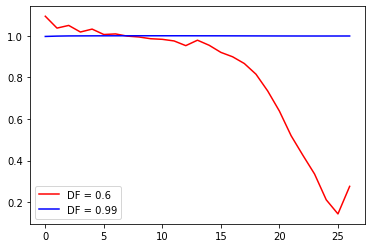

In [129]:
import matplotlib.pyplot as plt

critic_loss_1: list[float] = list()
critic_loss_2: list[float] = list()
with open('results_1.txt', 'r') as file:
    for line in file.read().split('\n'):
        try: critic_loss_1.append(float(line.split(';')[1]))
        except Exception: continue
with open('results_2.txt', 'r') as file:
    for line in file.read().split('\n'):
        try: critic_loss_2.append(float(line.split(';')[1]))
        except Exception: continue

plt.plot(critic_loss_1[3:], color='red', label='DF = 0.6')
plt.plot(critic_loss_2[3:], color='blue', label ='DF = 0.99')
plt.legend()
plt.show()

### Good Luck!